# Reinforcement Learning

In this notebook you will learn how to implement from scratch the Q-Learning algorithm for deterministic Markov
Decision Process and how to use the Deep Q-Learning algorithm using the TensorFlow-Agents library.

Imagine we want to train an impostor from
[Among Us](https://en.wikipedia.org/wiki/Among_Us) to make it capable of finding the closest vent to
hide himself. To simplify this task we assume that the impostor moves in a grid world.

We can model the impostor in this world as an agent that implements 4 actions,
move up, move down, move right and move left,
and we can model the environment as a grid world where the agent gets rewarded only once it has achieved its goal,
it has found the vent.

## The Environment

If in supervised learning, we would usually spend most of our time collecting and cleaning the data, in RL this
time is spent in designing the environment. Following we design a `GridWorld` class.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

class GridWold:

    def __init__(self, n, init_pos=(0, 0), target_pos=None):
        """
        A simple environment
        :param n: The size of the world.
        :param init_pos: The initial position of the agent. The agent start at the top-left corner by default.
        :param target_pos: The position of the goal. The goals is set to the bottom-right corner by default.
        """
        self.n = n
        self.init_pos = init_pos
        self.pos = init_pos
        if target_pos is None:
            self.target_pos = (n - 1, n - 1)
        else:
            self.target_pos = target_pos

    def reset(self, pos=None):
        """
        This method resets the environment.
        :param pos: If we set the position, the agent will start not from the default position by from the
        position set. This is useful when we will add some randomness in the training.
        :return:
        """
        if pos is None:
            self.pos = self.init_pos
        else:
            self.pos = pos
        return self.pos

    def get_available_actions(self):
        """
        This method returns the set of available actions the agent can perform given its current position.
        :return: The set of available actions.
        """
        # if the agent has reached the vent, then no actions are available.
        if self.pos == self.target_pos:
            res = {}
        else:
            # all actions
            res = {'up', 'down', 'right', 'left'}
            # remove actions if the agent is at the edges of the world.
            if self.pos[0] == 0:
                res.discard('left')
            elif self.pos[0] == self.n - 1:
                res.discard('right')
            if self.pos[1] == 0:
                res.discard('up')
            elif self.pos[1] == self.n - 1:
                res.discard('down')
        return res

    def step(self, action: str):
        """
        This method executes an action and changes the state of the agent. It returns the new position of the agent and
        the reward received.
        :param action: The action to execute.
        :return: The position and reward.
        """
        # executes an action
        if action == 'left':
            self.pos = (self.pos[0] - 1, self.pos[1])
        elif action == 'right':
            self.pos = (self.pos[0] + 1, self.pos[1])
        elif action == 'down':
            self.pos = (self.pos[0], self.pos[1] + 1)
        elif action == 'up':
            self.pos = (self.pos[0], self.pos[1] - 1)

        # if the agent has achieved the goal, it returns a reward of 100, zero otherwise.
        if self.pos == self.target_pos:
            return self.pos, 100
        else:
            return self.pos, 0

    def render(self):
        """
        This method renders the environment and the agent.
        """
        n = self.n
        agent = OffsetImage(plt.imread('imgs/agent.png'), zoom=1 / (2 * n))
        target = OffsetImage(plt.imread('imgs/target.png'), zoom=10 / (2 * n))

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1)
        for j in range(n + 1):
            ax.axvline(x=j / n)
            ax.axhline(y=j / n)

        ab_target = AnnotationBbox(target,
                                   xy=((self.target_pos[0] + 0.5) / n, 1 - (self.target_pos[1] + 0.7) / n),
                                   frameon=False)
        ax.add_artist(ab_target)

        ab_agent = AnnotationBbox(agent,
                                  xy=((self.pos[0] + 0.5) / n, 1 - (self.pos[1] + 0.5) / n),
                                  frameon=False)
        ax.add_artist(ab_agent)
        plt.show()

Let's now instantiate a gird-world of size 5 and render it. If we use the default parameters, you should see the
impostor on the top-left corner, and the vent on the bottom-right corner.

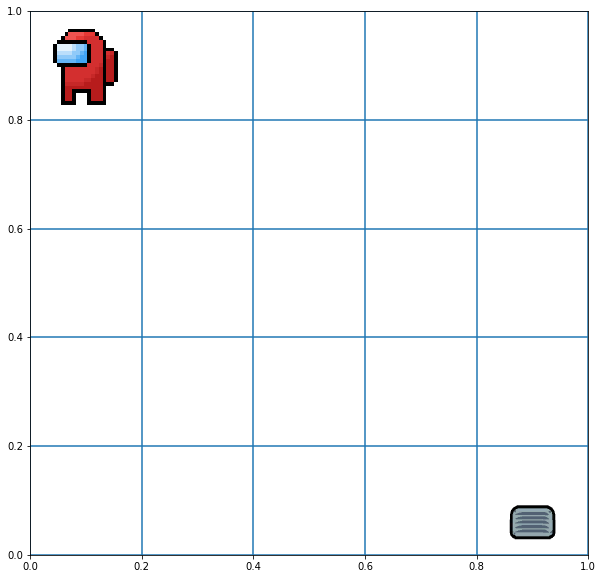

In [2]:
env = GridWold(5)
env.render()

## A Random Policy

We will now simulate a random policy. An agent that navigates the world performing random actions. This agent will
execute actions for a given number of times. While executing the actions
we will also count the number of times the agent has achieved its goal (the number of episodes).

Note that we are slowing down the execution of this policy to make this policy visible; We add a 1ms delay at every
agent step.

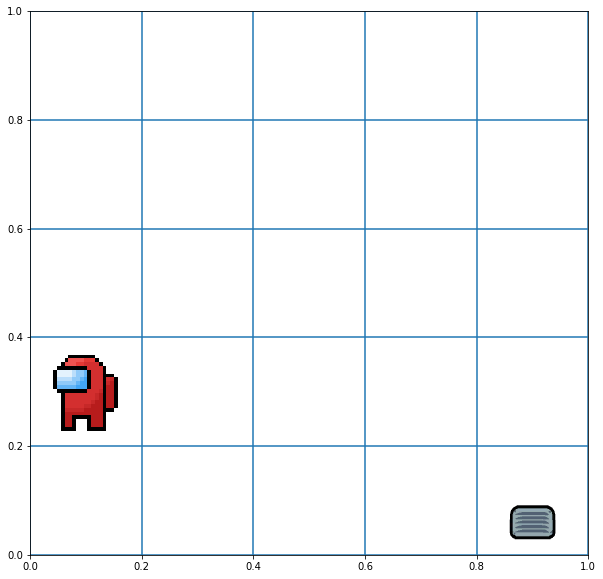

 32%|███▏      | 319/1000 [01:29<03:36,  3.15it/s]

Iteration: 319 of Episodes 4
Available actions: {'up', 'right'}
Action taken: up
Position: (0, 3)
Reward: 0


In [ ]:
import time
import random
from tqdm import tqdm
from IPython import display

# the number of actions the agent will execute in total
total_steps = 1000

episodes = 0
for n in tqdm(range(total_steps)):
    # delay
    time.sleep(0.1)
    display.clear_output(wait=True)
    available_actions = env.get_available_actions()
    # if no actions are available then the agent has reached the goal
    if not available_actions:
        env.reset()
        episodes += 1
    else:
        action = random.sample(available_actions, 1)[0]
        pos, reward = env.step(action)

    env.render()
    print(f'Iteration: {n+1} of Episodes {episodes}')
    print(f'Available actions: {available_actions}')
    print(f'Action taken: {action}')
    print(f'Position: {pos}')
    print(f'Reward: {reward}')

## Q-Learning

We will now implement the Q-learning algorithm to learn the Q-values. These Q-values will be stored in a table called
`q_table`. To pick the next action the agent will choose the action that maximizes the Q-value.

In [ ]:
def key_with_max_value(d):
    max_value = max(d.values())
    max_keys = []
    for key, value in d.items():
        if value == max_value:
            max_keys.append(key)
    return random.sample(max_keys, 1)[0]

# learning rate
l = 0.9
# the number of actions the agent will execute in total
total_steps = 1000
# q-values
q_table = {}

# reset env
pos = env.reset()

# render env
env.render()
time.sleep(0.1)
display.clear_output(wait=True)

episodes = 0
for n in tqdm(range(total_steps)):
    # delay
    time.sleep(0.1)
    display.clear_output(wait=True)
    # get available actions
    available_actions = env.get_available_actions()
    # if no actions are available then the agent has reached the goal
    if not available_actions:
        episodes += 1
        env.reset()
    else:
        # if this state exists in the q_table extract the actions
        if pos in q_table:
            action_probs = q_table[pos]
        else:  # else initialize the probs to 0
            action_probs = {a: 0 for a in available_actions}
            q_table[pos] = action_probs

        # select the best action
        action = key_with_max_value(action_probs)
        # execute this action
        pos, reward = env.step(action)
        # update the q-value
        if pos in q_table:
            action_probs[action] = reward + l * max(q_table[pos].values())
        else:
            action_probs[action] = reward

    # print statistics
    env.render()
    print(f'Iteration: {n + 1} of Episodes {episodes}')
    print(f'Available actions: {available_actions}')
    print(f'Action taken: {action}')
    print(f'Reward: {reward}')
    print(f'Position: {pos}')
    print(f'Q-Values:')
    for key in sorted(q_table):
        print(key, q_table[key])

Now that we have trained the agent we can test it. Compare the performance of this agent against the random policy.

In [ ]:
# the number of actions the agent will execute in total
total_steps = 1000

# reset env
pos = env.reset()
for n in tqdm(range(total_steps)):
    time.sleep(0.1)
    display.clear_output(wait=True)
    # get available actions
    available_actions = env.get_available_actions()
    if not available_actions:
        episodes += 1
        env.reset()
    else:
        # select the best action
        action = key_with_max_value(q_table[pos])
        # execute this action
        pos, reward = env.step(action)

    env.render()
    print(f'Iteration: {n + 1} of Episodes {episodes}')
    print(f'Available actions: {available_actions}')
    print(f'Action taken: {action}')
    print(f'Reward: {reward}')
    print(f'Position: {pos}')

## An example of Ready-Made Environments (MiniGrid)

Here I provide you with an example of a ready-made environment where you can test RL algorithms.
These environments are defined by the [MiniGrid](https://github.com/maximecb/gym-minigrid).

Before executing the next code, please make sure that this package is correctly installed.

In [ ]:
!pip install gym-minigrid

In [ ]:
from gym_minigrid.wrappers import *

env = gym.make('MiniGrid-Empty-16x16-v0')

This is how the environment looks like at the beginning. We have a grid world with an agent in the top-left corner
that can navigate this empty room. On the bottom-right corner we have the target location.

In [ ]:
plt.figure(figsize=(9, 9))
plt.imshow(env.render(mode='rgb_array'))
plt.show()

We can access the actions available to the agent as follows:

In [ ]:
for action in list(env.actions):
    print(action)

In [ ]:
total_steps = 100

for n in tqdm(range(total_steps)):
    time.sleep(0.1)
    display.clear_output(wait=True)
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()
    action = env.action_space.sample()
    _, reward, _, _ = env.step(action)

    print(f'Iteration: {n + 1} of Episodes {episodes}')
    print(f'Action taken: {action}')
    print(f'Reward: {reward}')

## Deep Q-Learning with TF-Agents

This example shows how to train a
[DQN (Deep Q Networks)](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
agent using the TF-Agents library.

Before executing the next code, please make sure that these packages are correctly installed.

In [ ]:
!pip install tensorflow
!pip install tf-agents
!pip install pyglet==1.5.11

### The Cartpole Environment

We will train a DQN agent for the Cartpole environment.

In [ ]:
from tf_agents.environments import suite_gym, tf_py_environment

env = suite_gym.load('CartPole-v1')
env = tf_py_environment.TFPyEnvironment(env)

env.reset()
env.render()

print('Observation Spec:', env.time_step_spec().observation)
print('Reward Spec:', env.time_step_spec().reward)
print('Action Spec:', env.action_spec())

Let's now try executing always one action.

In [ ]:
import numpy as np
time_step = env.reset()
print('Time step:')
print(time_step)

while not time_step.is_last():
    action = np.array(1, dtype=np.int32)
    time_step = env.step(action)
    env.render()

We can see that by doing this the episode ends quickly. This naive agent fails quickly.

## The DQN Agent

The DQN agent can be used in any environment which has a discrete action space.
At the heart of a DQN Agent is a QNetwork, a neural network model that can learn to predict
Q-Values (expected returns) for all actions, given an observation from the environment.

The QNetwork consists of a sequence of Dense layers, where the final layer
will have 1 output for each possible action.

In [ ]:
import tensorflow as tf
from tf_agents.networks import sequential
from tf_agents.specs import tensor_spec

fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))


# QNetwork consists of a sequence of Dense layers followed by a dense layer with `num_actions` units to generate one
# q_value per available action as it's output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Now we instantiate a `DqnAgent`. The agent constructor also requires an
optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [ ]:
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss)

agent.initialize()

Before training the DQN agent we can test how a random policy would behave in this environment.

In [ ]:
from tf_agents.policies import random_tf_policy

random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(), env.action_spec())

We also create a helper function that will allow us render any policy.

In [ ]:
def render_policy(policy):
    time_step = env.reset()
    env.render()
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = env.step(action_step.action)
        env.render()

render_policy(random_policy)

Given a policy we are interested in evaluating what is its average return.
To do that we run the policy for multiple episodes and average their returns.

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):
  res = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    res += episode_return

  avg_return = res / num_episodes
  return avg_return.numpy()[0]

print('Average return of the random policy:', compute_avg_return(env, random_policy))


## Replay Buffer

The replay buffer keeps track of data collected from the environment.
This allows the agent to train on previous experiences. This helps in stabilizing the training.
We use the `TFUniformReplayBuffer`, as it is the most common.

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer_max_length = 100000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size,
    max_length=replay_buffer_max_length)

We can now execute the random policy in the environment for a few steps, and
record the data in the replay buffer.

In [ ]:
from tf_agents.trajectories import trajectory

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

initial_collect_steps = 100
collect_data(env, random_policy, replay_buffer, initial_collect_steps)

## Training the DQN Agent

Two things must happen during the training loop:
-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodically evaluates the policy and prints the current score.

In [ ]:
batch_size = 64

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(env, agent.policy)
returns = [avg_return]

collect_steps_per_iteration = 1
num_iterations = 10000
iterator = iter(dataset)
agent.train_step_counter.assign(0)
for _ in tqdm(range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, _ = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % 200 == 0:
    print('step = {0}:\n\tloss = {1}'.format(step, train_loss))
    avg_return = compute_avg_return(env, agent.policy)
    print('\taverage return = {1}'.format(step, avg_return))
    returns.append(avg_return)

We can now see how the training progressed by plotting the average return over the iterations.

In [ ]:
import matplotlib.pyplot as plt
iterations = range(0, num_iterations + 1, 200)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

Let's now see how the agent behaves.

In [ ]:
render_policy(agent.policy)